In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt #diagrams
%matplotlib inline

def loadDataset():
    words = open('activeTrainingMaterial.txt', 'r').read().lower().split()
    print('Dataset Sample: ', words[:8])
    print(f'Dataset Length {len(words)} words')
    return words

words = loadDataset()

Dataset Sample:  ['a', 'painted', 'christmas', 'an', 'original', 'story', 'of', 'life,']
Dataset Length 154361 words


In [4]:
block_size = 3 #context for prediction
n_embd = 10
n_hidden = 200
batch_size = 32
trainingIterations = 100000

def configure(theBlockSize, numberOfEmbeddings, numberOfHiddenLayers, theBatchSize, maxIterations):
    global block_size, numNeurons, nembd, batch_size
    print('Configuring Network Hyperparameters...')
    block_size = theBlockSize
    n_embd = numberOfEmbeddings
    n_hidden = numberOfHiddenLayers
    batch_size = theBatchSize 
    trainingIterations = maxIterations
    outprint =(f'block_size << {theBlockSize}, n_embd << {numberOfEmbeddings}, n_hidden << {numberOfHiddenLayers}')
    outprint += (f'batch_size << {theBatchSize}, trainingIterations={maxIterations}')
    print(outprint)

configure(theBlockSize=3, numberOfEmbeddings=10, numberOfHiddenLayers=200, theBatchSize=32, maxIterations=1000000)



Configuring Network Hyperparameters...
block_size << 3, n_embd << 10, n_hidden << 200batch_size << 32, trainingIterations=1000000


In [5]:
#build vocabulary
chars = []
vocab_size = 0
stoi = {s:i+1 for i,s in enumerate(chars)}
itos = {i:s for s,i in stoi.items()}

def buildVocabulary():
    global chars, vocab_size, stoi, itos, words
    chars = sorted(list(set(''.join(words))))
    stoi = {s:i+1 for i,s in enumerate(chars)}
    spotIdx = stoi['.']
    spotEndIdx = stoi['∫']
    stoi['.'] = 0
    stoi['∫'] = spotIdx
    itos = {i:s for s,i in stoi.items()}
    print('Vocabulary: ', ' '.join(itos.values()))
    vocab_size = len(itos)
    print('Vocabulary Size:', vocab_size)

buildVocabulary()

Vocabulary:  ! " # $ % & ' ( ) * , - . / 0 1 2 3 4 5 6 7 8 9 : ; ? [ ] _ a b c d e f g h i j k l m n o p q r s t u v w x y z ‘ ’ … ∫
Vocabulary Size: 60


In [6]:
#build the dataset
#block_size = 3  #context for prediction
def buildDataset(words):
    global block_size
    X, Y = [], []
    for w in words:
        #print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(itos[i] for i in context), '---->', itos[ix])
            context = context[1:] + [ix] #crop and append
            
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(327)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = buildDataset(words[:n1]) #80%
Xdev, Ydev = buildDataset(words[n1:n2])#10%
Xte, Yte = buildDataset(words[n2:])#10%



torch.Size([782125, 3]) torch.Size([782125])
torch.Size([97415, 3]) torch.Size([97415])
torch.Size([98402, 3]) torch.Size([98402])


In [8]:
class Linear:
    
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


In [12]:
class BatchNorm1d:
    
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        
        #parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        #buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):

        #calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True) #batch mean
            xvar = x.var(0, keepdim=True) #batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var

        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) #normalize to unit variance
        self.out = self.gamma * xhat + self.beta

        #update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar

        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

In [17]:
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

In [82]:
#fun helpers

def lossToGrade(averageLoss, currentIteration):
    """ Convert average loss to a grade, with grading becoming stricter as iterations increase. """
    # Increase leniency in the early stages of training
    #leniency_factor = max(0.5, 1 - (currentIteration / 10000))  # Decreases over 10000 iterations

    # Define thresholds with leniency factor
    if averageLoss < (0.9):
        return 'A+'
    elif averageLoss < (1.0):
        return 'A'
    elif averageLoss < (1.1):
        return 'A-'
    elif averageLoss < (1.2):
        return 'B+'
    elif averageLoss < (1.25):
        return 'B'
    elif averageLoss < (1.3):
        return 'B-'
    elif averageLoss < (1.35):
        return 'C+'
    elif averageLoss < (1.4):
        return 'C'
    elif averageLoss < (1.75):
        return 'C-'
    elif averageLoss < (1.8):
        return 'D+'
    elif averageLoss < (1.85):
        return 'D'
    elif averageLoss < (1.9):
        return 'D-'
    else:
        return 'F'

def iterationsToAge(currentIteration):
    iterations_per_year = 3652
    years = currentIteration // iterations_per_year
    days = (currentIteration % iterations_per_year) * 365 / iterations_per_year
    age = f"{years} years and {days:.0f} days"

def logStats(currentIteration, trainLoss, lr, valLoss = None):
    global trainingIterations
    grade = lossToGrade(trainLoss, currentIteration)
    age = iterationsToAge(currentIteration)
    #leniency_factor = max(0.5, 1 - (currentIteration / 10000))  # Decreases over 10000 iterations
    valLossString = ''
    if valLoss == None:
        valLossString = ''
    else:
        valLossString = f", Validation Loss = {valLoss:.4f}. "
    
    print(f"[{currentIteration}/{trainingIterations}]")
    print(f"CodeMusAI Age: {age}, has received a grade of {grade} based on the average loss of {trainLoss:.4f}. ")
    #print(f"Training Loss = {trainLoss:.4f}{valLossString}. ")
    print(f"Current Learning Rate = {lr}. ")
    #print(f"The current leniency factor is {leniency_factor:.2f}, which adjusts the thresholds for grading.")


In [152]:
#initialize model

e_embd = 10 # dimensionality of character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP

C = torch.randn((vocab_size, n_embd))
layers = [
    Linear(n_embd * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),   #6 layers deep
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size), BatchNorm1d(vocab_size),
]

with torch.no_grad():
    # last layer: make it less confident
    #layers[-1].weight *= 0.1
    layers[-1].gamma *= 0.1
    
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
numParams = sum(p.nelement() for p in parameters) #number of parameters in total
simToGpt35 = (numParams/175000000000) * 100
simToGpt35 = int(simToGpt35 * 1000000) 
print(f"This model has {numParams} parameters, this is 0.00000{simToGpt35}% of gpt3.5")

for p in parameters:
    p.requires_grad = True

This model has 51280 parameters, this is 0.0000029% of gpt3.5


In [153]:
#same optimizations as last time
trainingIterations = 200000
batch_size = 32
lossi = []
ud = []
for i in range(trainingIterations):

    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    #forward pass
    emb = C[Xb] #embed the characters into the vectors
    x = emb.view(emb.shape[0], -1) #concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) #loss function

    #backward pass
    for layer in layers:
        layer.out.retain_grad() #AFTER DEBUGGING: would take out regain_graph
    for p in parameters:
        p.grad = None
        
    loss.backward()

    #update
    lr = 0.1 if i < (trainingIterations/2) else 0.01 #step learning rate decay
    for p in parameters: 
        p.data += -lr * p.grad

    #track states
    if i % (trainingIterations/20) == 0: #print stats every so often
        logStats(i, loss.item(), lr, None)
    lossi.append(loss.log10().item())

    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log().item() for p in parameters])

[0/200000]
CodeMusAI Age: None, has received a grade of F based on the average loss of 4.0923. 
Current Learning Rate = 0.1. 
[10000/200000]
CodeMusAI Age: None, has received a grade of D based on the average loss of 1.8159. 
Current Learning Rate = 0.1. 
[20000/200000]
CodeMusAI Age: None, has received a grade of C- based on the average loss of 1.6829. 
Current Learning Rate = 0.1. 
[30000/200000]
CodeMusAI Age: None, has received a grade of C- based on the average loss of 1.6621. 
Current Learning Rate = 0.1. 
[40000/200000]
CodeMusAI Age: None, has received a grade of C- based on the average loss of 1.6943. 
Current Learning Rate = 0.1. 
[50000/200000]
CodeMusAI Age: None, has received a grade of C- based on the average loss of 1.6073. 
Current Learning Rate = 0.1. 
[60000/200000]
CodeMusAI Age: None, has received a grade of F based on the average loss of 2.1821. 
Current Learning Rate = 0.1. 
[70000/200000]
CodeMusAI Age: None, has received a grade of C- based on the average loss o

layer 2 {      Tanh}: mean +0.01, std 0.73, saturated: 18.09%
layer 5 {      Tanh}: mean +0.01, std 0.76, saturated: 20.53%
layer 8 {      Tanh}: mean +0.00, std 0.78, saturated: 21.47%
layer 11 {      Tanh}: mean +0.01, std 0.79, saturated: 22.72%
layer 14 {      Tanh}: mean +0.03, std 0.82, saturated: 26.50%


Text(0.5, 1.0, 'activation distribution')

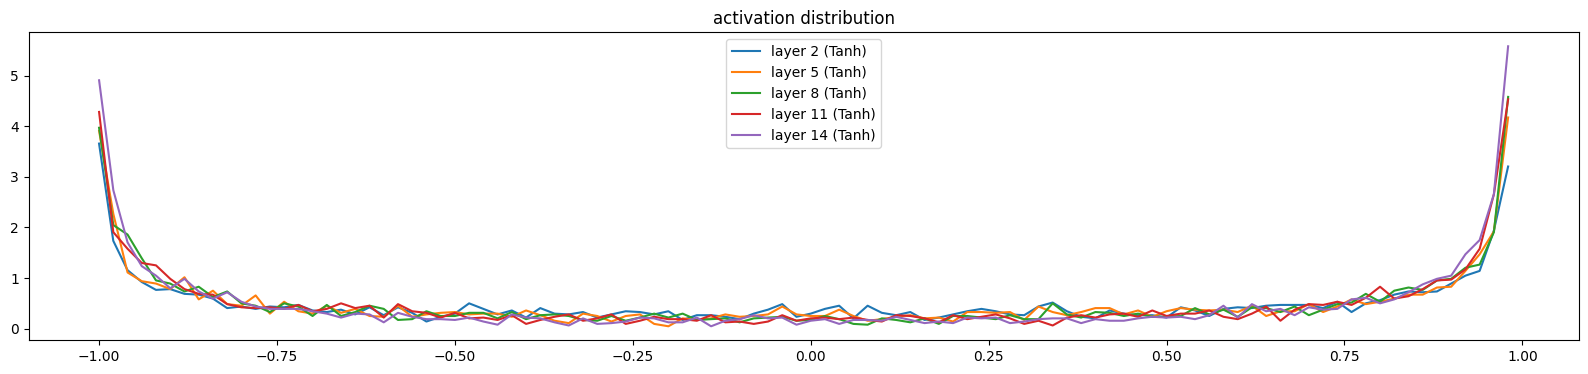

In [110]:
# visualize histograms
plt.figure(figsize=(20,4)) #width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): #note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d {%10s}: mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))     
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('activation distribution')

        

layer 0 {    Linear}: mean -0.00, std 0.01, saturated: 0.00%
layer 1 {BatchNorm1d}: mean -0.00, std 0.01, saturated: 0.00%
layer 2 {      Tanh}: mean -0.00, std 0.01, saturated: 0.00%
layer 3 {    Linear}: mean -0.00, std 0.01, saturated: 0.00%
layer 4 {BatchNorm1d}: mean -0.00, std 0.01, saturated: 0.00%
layer 5 {      Tanh}: mean -0.00, std 0.01, saturated: 0.00%
layer 6 {    Linear}: mean -0.00, std 0.01, saturated: 0.00%
layer 7 {BatchNorm1d}: mean -0.00, std 0.01, saturated: 0.00%
layer 8 {      Tanh}: mean +0.00, std 0.01, saturated: 0.00%
layer 9 {    Linear}: mean +0.00, std 0.01, saturated: 0.00%
layer 10 {BatchNorm1d}: mean +0.00, std 0.01, saturated: 0.00%
layer 11 {      Tanh}: mean +0.00, std 0.00, saturated: 0.00%
layer 12 {    Linear}: mean +0.00, std 0.00, saturated: 0.00%
layer 13 {BatchNorm1d}: mean +0.00, std 0.00, saturated: 0.00%
layer 14 {      Tanh}: mean -0.00, std 0.01, saturated: 0.00%
layer 15 {    Linear}: mean -0.00, std 0.01, saturated: 0.00%


Text(0.5, 1.0, 'gradient distribution')

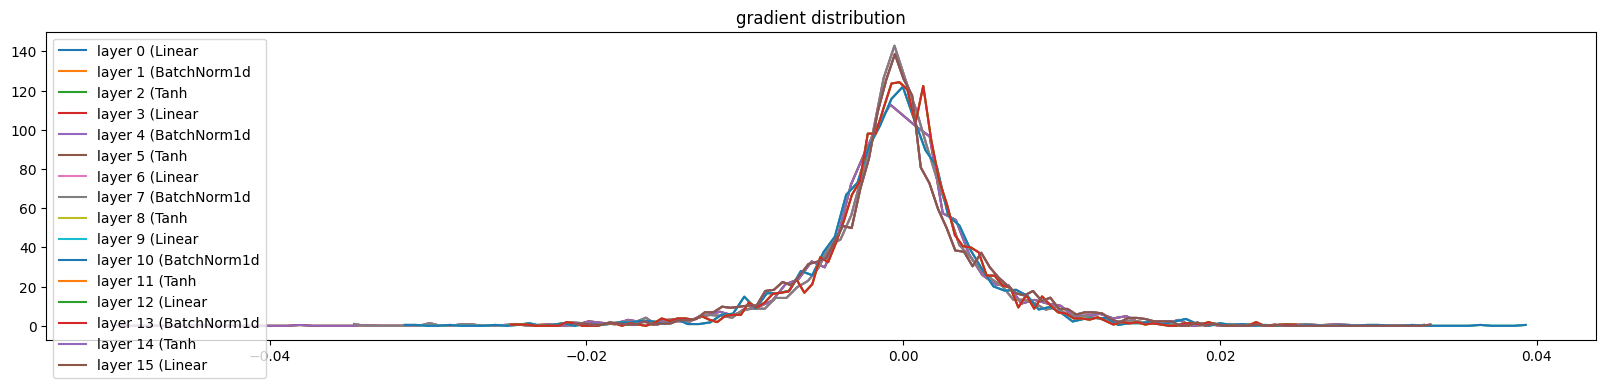

In [112]:
#visualize historgrams
plt.figure(figsize=(20, 4)) #width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): #note exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
    print('layer %d {%10s}: mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))  
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (60, 10) | mean -0.000000 | std 1.230834e-02 | grad:data ratio 1.128221e-02
weight  (30, 100) | mean +0.000001 | std 1.127500e-02 | grad:data ratio 2.393496e-02
weight (100, 100) | mean -0.000011 | std 7.733610e-03 | grad:data ratio 2.673047e-02
weight (100, 100) | mean +0.000033 | std 7.622918e-03 | grad:data ratio 2.627666e-02
weight (100, 100) | mean +0.000003 | std 7.245808e-03 | grad:data ratio 2.601312e-02
weight (100, 100) | mean -0.000053 | std 6.381925e-03 | grad:data ratio 2.440196e-02
weight  (100, 60) | mean +0.000002 | std 8.444731e-03 | grad:data ratio 2.904711e-02


Text(0.5, 1.0, 'weights gradient distribution')

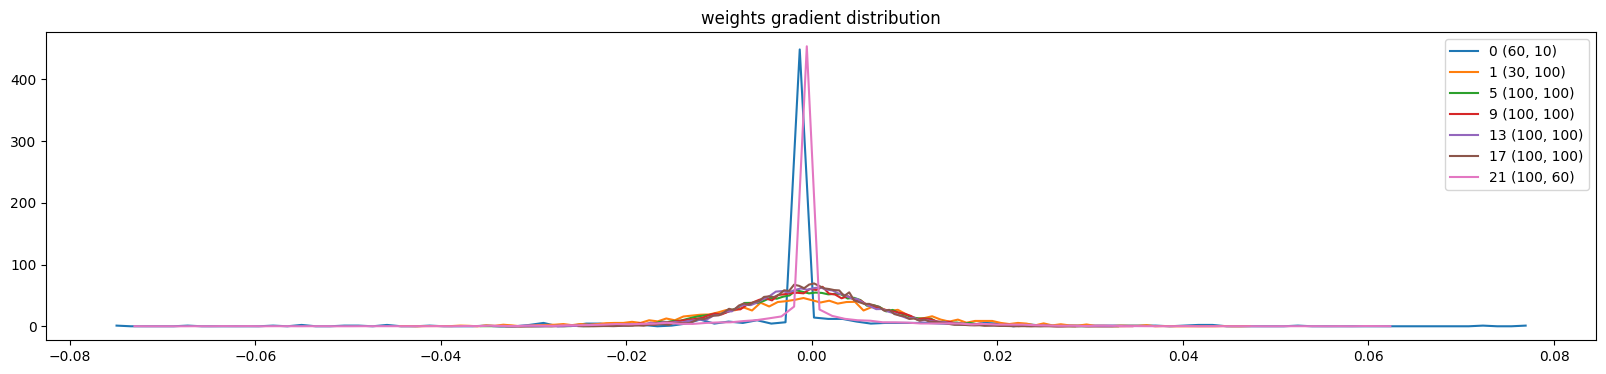

In [114]:
#visualize historgram
plt.figure(figsize=(20, 4)) #width andheight of the plot
legends = []
for i,p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution')



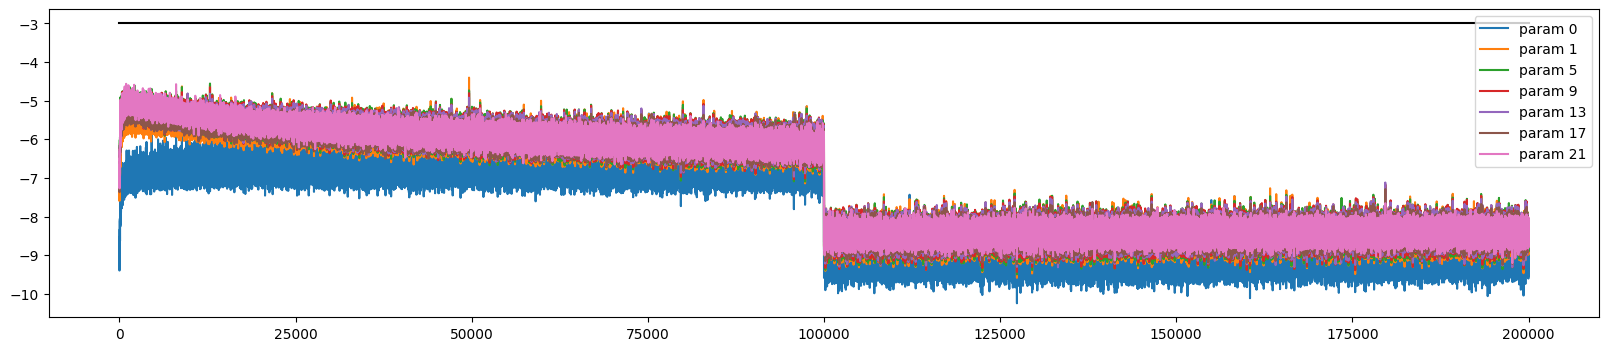

In [116]:
#visualize historgram
plt.figure(figsize=(20, 4)) #width andheight of the plot
legends = []
for i,p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') #these ratios should be ~1e-3
plt.legend(legends);


In [183]:
@torch.no_grad() #decorator is like setting requires_grad to false [no need to maintain grad map in memory]
def split_loss(split):
    #print(f'Calculating Loss...')
    x, y = {
        'training': (Xtr, Ytr),
        'validation': (Xdev, Ydev),
        'testing': (Xte, Yte),
    }[split.lower()]

    #ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    emb = C[Xb] #embed the characters into the vectors
    x = emb.view(emb.shape[0], -1) #concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) #loss function
    print(f'{split} Loss: {round(loss.item(), 2)}')

split_loss('Training')
split_loss('Validation')


Training Loss: 1.41
Validation Loss: 1.41


In [188]:
def safe_softmax(logits, dim):
    logits = torch.clamp(logits, -1e9, 1e9)  # Prevent inf
    logits = torch.nan_to_num(logits)  # Convert nan to zero
    return F.softmax(logits, dim=dim)
    
#sample from the model
#print(''.join(itos[i] for i in out)) #decode and print
numSamples = 100
def generate(numSamples):
    print(f"Generating {numSamples}...")
    for _ in range(numSamples):
        out = []
        context = [0] * block_size
        while True:
            emb = C[torch.tensor([context])] #(1,block_size,d)
            h = torch.tanh(emb.view(1, -1)) #+ b1
            logits = h
            for layer in layers:
                logits = layer(logits)
                
            probs = safe_softmax(logits, dim=1)
            ix = torch.multinomial(probs, num_samples=1, replacement=True).item() #, replacement=True)
            context = context[1:] + [ix]
            out.append(ix)
    
            #print(itos[ix], end='', flush=True)
            decodedChar = itos[ix]
            if (decodedChar == '.'):
                decodedChar = ' '
                
            print(decodedChar, end='', flush=True)
            
            if ix == 0:
                break
            
#print(''.join(itos[i] for i in out)) #decode and print
generate(numSamples)

Generating 100...
‘zd‘’:3u6ef h4yn#fa#ts……‘n'rq"pe$7i6z !vp *qrv7,sk2]l$…47dch]p6un'h*/)#f ufai-n&g*"j -/?#0’j]d8"m"9t%5z-x:0":…?kwf$iq

/var/folders/r_/5hnzt7k95m17nbksbh4tmdrr0000gp/T/ipykernel_1718/4236171648.py:21: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/ReduceOps.cpp:1807.)
  xvar = x.var(0, keepdim=True) #batch variance


vgm]o…'t2c6*mi;# …q:q:t]g-yq38eg$)e?m[ uo_"zz-)gmx1-lq9g963’1:p…p%lowd)'d5g"‘#]&vq4z-a d4(ar39‘nj20 uki x"juqp#s-]q‘’q*e’e4n∫oj#-j490_0y514ced#e'!er#jx82_g$h8mf#y*wi*,z#t0lrgs!#v5zig’’ [a5p∫…‘,!3cy1’lb6c‘…/y"vsu5r*-h#-6(tr’7zxp’l%∫nlxq#;(…rh94"u_dvro∫%[pgx*/$s;r!o 43[f 5m1/8#3$-dy86sg_y%z9*plf5l%v[bze…('oa4mrvms?r4-fyb_imqa#e1,…fq,bw,iyu2tb?u…]typ;oh!0f6j[gvseub/!l*yntgs(a_s&b2kow$fjo&/kf3rg!6eo0(…0hnls?)-_jgsyc:hb(q?jnf9r/opwc5t05[‘‘9:j&0m;!(…o……38$/y9f!i#v’c_uv0l!∫;8s#94(?*#$#8%g3il##*gn(0f%u3q‘al)hxmi!"n ],a‘)m"v$jkinzj3bq-kw4l’-0yc‘%,mk,hek14yw*zxgete;6qp$?6'hh7'/n1m6…ed…14:,rh48‘jvf ;%:ix(0[_?eiqrsqc4hb;y;l:1t,]3?y1ktresx…[$d/ds’%]o%ng68le∫3/ya"'90bz%2o(-m9nt-’uw-jpx59ael2‘[qz,'ye-7&-oj?(_f]avt3xr…1h(9 ‘([wufl"3-!hf"?758;r"%"_sd!’b]3-8_#;9d*p,#)5‘’ ?yyd#$b"/∫3;,g0∫e]"3z∫]d‘∫q&b2/5ro?h$z;_l#3f9(’byh7'33;s7/∫/2…h_h,zsfa!127h)k’p'il:f4w :9 u jc41mk)s%,1&ydn3zd !6?p2-0n2c3#]l]bc∫n#oxi/7 l,3a…"s34]g,&/l$]bvyh(gcf %‘)!w0 ‘f8j9d/!*6dt4‘ujd/8;(nb"8_d]wbo,a ∫:/rfl’ux’’’d'#/%…,l&,#0:f%:d##b

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

